# Homework 3 - EECS 600 Deep Learning

Name: Andrew Tarnoff

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you may use any of the functionality within tensorflow.

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 12/6/19 - midnight EST

100 Points Total

In [0]:
#%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import random

from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten,Input,Reshape

import random
from tqdm import tqdm

%matplotlib inline
tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = (np.reshape(train_images, (len(train_images),28,28,1)).astype('float32') - 127.5) / 127.5
test_images = (np.reshape(test_images, (len(test_images),28,28,1)).astype('float32') - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Loading the dataset returns four NumPy arrays:

The train_images and train_labels arrays are the training set—the data the model uses to learn.
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

Label |	Class
------|------
0 |	T-shirt/top
1 |	Trouser
2 |	Pullover
3 |	Dress
4 |	Coat
5 |	Sandal
6 |	Shirt
7 |	Sneaker
8 |	Bag
9 |	Ankle boot

Each image is mapped to a single label. Since the class names are not included with the dataset.

More information and a working example using this dataset here: https://www.tensorflow.org/tutorials/keras/classification.

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.


# Question 1
Implement a Deep Convolutional Generative Adversarial Network for generating fasion MNIST photos.

In [0]:
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

def plotImage(img):
  figure, axes = plt.subplots(nrows=2, ncols=1)
  figure.set_size_inches(5, 5)
  
  for idx, axis in enumerate(axes.flat):
    reconstrImage = np.reshape(img, (28, 28))*127.5 + 127.5
    
    axis.imshow(reconstrImage, cmap=plt.cm.gray)
    axis.set_frame_on(False)
    axis.set_axis_off()

def getRandomSampleFromDataset():
  idx = random.choice(range(len(train_images)))
  return train_images[idx, :]

plotImage(getRandomSampleFromDataset())

NameError: ignored

# DEFINING THE GENERATOR AND DIFFERENTIATOR

In [0]:
def make_generator_model():
    model = tf.keras.Sequential(name = 'Generator')
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential(name = 'Discriminator')
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

#Test these
generator = make_generator_model()
print(generator.summary())

discriminator = make_discriminator_model()
print(discriminator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

Test These Models:

tf.Tensor([[0.00264615]], shape=(1, 1), dtype=float32)


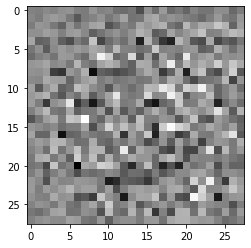

In [0]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

pred = discriminator(generated_image, training=False)
print(pred)

## DEFINE LOSS, AND DEFINE OPTIMIZER

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer     = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# SETUP TRAINING

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, noise_dim=100):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train_OLD(num_epochs=100, batch_size=64):
  generator = make_generator_model()
  discriminator = make_discriminator_model()

  gen_loss_epochs = []
  disc_loss_epochs = []

  train_dataset = tf.data.Dataset.from_tensor_slices(train_images)

  for epoch in range(1, num_epochs + 1):
    train_batches = train_dataset.shuffle(100).batch(batch_size)
    
    gens = []
    discs = []
    for sampleImages in train_batches:
      gen_loss, disc_loss = train_step(generator, discriminator, sampleImages)

      gen = gen_loss.numpy().mean()
      disc = disc_loss.numpy().mean()
      gens.append(gen)
      discs.append(disc)
    print(f'On epoch {epoch} the generator loss is {np.mean(gens):.2f}, the discriminator loss is {np.mean(discs):.2f}')
    gen_loss_epochs.append(np.mean(gens))
    disc_loss_epochs.append(np.mean(discs))
  return gen_loss_epochs, disc_loss_epochs, generator, discriminator

def train(dataset, num_epochs):
  gen_loss_epochs = []
  disc_loss_epochs = []

  for epoch in range(1, num_epochs+1):
    gens = []
    discs = []
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen = gen_loss.numpy().mean()
      disc = disc_loss.numpy().mean()
      gens.append(gen)
      discs.append(disc)

    print(f'On epoch {epoch} the generator loss is {np.mean(gens):.2f}, the discriminator loss is {np.mean(discs):.2f}')
    gen_loss_epochs.append(np.mean(gens))
    disc_loss_epochs.append(np.mean(discs))

  return gen_loss_epochs, disc_loss_epochs, generator, discriminator


In [0]:
EPOCHS = 200
gen_loss, disc_loss, generator, discriminator = train(train_dataset, num_epochs=EPOCHS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
On epoch 0 the generator loss is 0.99, the discriminator loss is 0.87
On epoch 1 the generator loss is 0.91, the discriminator loss is 1.20
On epoch 2 the generator loss is 0.90, the discriminator loss is 1.17
On epoch 3 the generator loss is 0.85, the discriminator loss is 1.28
On epoch 4 the generator loss is 0.83, the discriminator loss is 1.30
On epoch 5 the generator loss is 0.89, the discriminator loss is 1.25
On epoch 6 the generator loss is 0.89, the discriminator loss is 1.25
On epoch 7 the generator loss is 0.98, the discriminator loss is 1.18
On epoch 8 the generator loss is 0.98, the discriminator loss is 1.14
On epoch 9 the generator loss is 1.04, the discriminator loss is 1.13
On epoch 10 the generator loss is 1.01, the discriminator loss is 1.15
On epoch 11 the generator loss is 1.08, the discriminator loss is 1.10
On epoch 12 the generator loss is 1.14, the discriminator loss i

Plot the loss functions for the generator and discriminator. Label them accordingly.

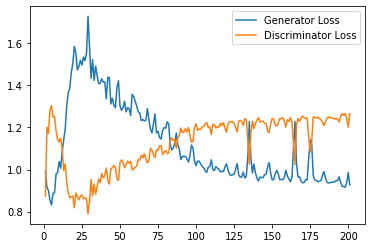

In [0]:
plt.figure()
x = range(1, EPOCHS+2)
plt.plot(x, gen_loss, x, disc_loss)
plt.legend(['Generator Loss', 'Discriminator Loss'])


Show three example generated photos using your model. Even though the images may not be perfect, it should be perceivable as a fashion photo.

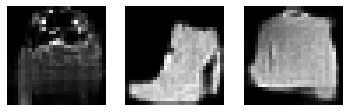

In [0]:
def plotGeneratorOutput(generator, numRows=10, numCols=10):
  results = generator(tf.random.uniform((numRows*numCols, 100), minval = -1.0, maxval = 1.0)).numpy()

  figure, axes = plt.subplots(nrows=numRows, ncols=numCols)
  figure.set_size_inches(2*numCols, 2*numRows)
  
  for idx, axis in enumerate(axes.flat):
    image = np.reshape(results[idx], (28,28))*127.5+127.5
    
    axis.imshow(image, cmap=plt.cm.gray)
    axis.set_frame_on(False)
    axis.set_axis_off()

plotGeneratorOutput(generator, 1, 3)

# Question 2
Design a method to conditionally generate photos of different labels. Pick two classes within the MNIST fasion dataset, and use them to conditionally generate photos of those two classes. You will likely need to include another outcome variable in the discriminator to account for this.

In [0]:
conditionalLabelNum = 10

#Takes in a 100+conditionalLabelNum vector
def make_cond_generator_model():
  model = tf.keras.Sequential(name = 'Conditional Generator')
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100 + conditionalLabelNum,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

def make_cond_discriminator_model():
  # define two sets of inputs
  inp_images = Input(shape=(28,28,1,))
  inp_oneHot = Input(shape=(conditionalLabelNum,))
  print(inp_oneHot)
  dense1 = Dense(784, activation='relu')(inp_oneHot)
  y = Reshape((28, 28, 1))(dense1)

  y = Model(inputs=inp_oneHot, outputs=y)
  imageModel = Model(inputs=inp_images, outputs=inp_images)

  #Concatenate new one hot encoding image with inputted images
  combined = layers.concatenate([imageModel.outputs, xFormModel.outputs])

  conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(combined)
  lRelu1 = layers.LeakyReLU()(conv1)
  drop1 = layers.Dropout(0.3)(lRelu1)

  conv2 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(drop1)
  lRelu2 = layers.LeakyReLU()(conv2)
  drop2 = layers.Dropout(0.3)(lRelu2)

  flat = layers.Flatten()(drop2)
  prob = layers.Dense(1, input_shape=(7*7*128,))(flat)
  print(prob)
  print(inp_images)
  print(inp_oneHot)
  # This model allows us to concatenate one hot encodings to the images and then get the discriminator output
  model = Model(inputs=[inp_images, inp_oneHot], outputs=prob, name='Conditional Discriminator')

  return model

#Test these
cond_generator = make_cond_generator_model()
print(generator.summary())

cond_discriminator = make_cond_discriminator_model()
print(discriminator.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 128)        

TypeError: ignored

Plot all of your loss functions and label them accordingly. 

Show three examples of photos generated of your first class.

Show three examples of photos generated of your second class.